In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="2"

Sat Jan 27 18:43:17 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   31C    P0    43W / 300W |     35MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [3]:
from model.main.enc_prior_latent_quantizer_dec import Model
from model.encoder.net_64_encoder import Encoder
from model.prior.dalle_rand_prior import Prior
from model.latent.dalle_lse_latent import Latent
from model.quantizer.dalle_nearest_quantizer import Quantizer
from model.decoder.net_64_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.img_size = 64
hp.n_resblocks = 6
hp.z_dim = 64
hp.n_prior_embeddings = 512
hp.init_log_sigma = 0
hp.const_sigma = False
hp.quantize = False
hp.prior_mu = 0.999
hp.noise = 1e-3
hp.z_activation = F.tanh
hp.M = hp.n_prior_embeddings

In [5]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Quantizer(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 1.2191162109375
encoder.encoder 1.2191162109375
prior 0.126953125
latent 3.814697265625e-06
quantizer 0.0
decoder 1.0611686706542969
decoder.decoder 1.0611686706542969
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train_dalle/train01.27-6/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, model_list, optimizer_list = load_model_list(save_dir, 660000, model_list, optimizer_list)

total 8588
-rw-rw-r-- 1 scpark scpark 1309826  1월 27 18:43 events.out.tfevents.1706347716.GPUSVR11
-rw-rw-r-- 1 scpark scpark 7471539  1월 27 18:28 save_0
-rw-rw-r-- 1 scpark scpark      40  1월 27 18:28 events.out.tfevents.1706347673.GPUSVR11


In [7]:
# path = '/data/scpark/save/lse/train_dalle/train01.19-7_tanh_0.999_lr1e-4/save_600000'
# checkpoint = torch.load(path, map_location=torch.device('cpu'))
# # warm start
# for i, (model, optimizer) in enumerate(zip(model_list, optimizer_list)):
#     model.load_state_dict(checkpoint['models_state_dict'][i], strict=False)
    
# print('done')

### Dataset

In [8]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CelebA

class MyCelebA(CelebA):
    """
    A work-around to address issues with pytorch's celebA dataset class.
    
    Download and Extract
    URL : https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing
    """
    
    def _check_integrity(self) -> bool:
        return True

root = '/data'
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(148),
                                       transforms.Resize(hp.img_size),
                                       transforms.ToTensor(),])
train_dataset = MyCelebA(root, split='train', transform=train_transforms, download=False)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
print('done')

done


In [9]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [10]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(8):
        plt.subplot(1, 8, i+1)
        plt.imshow(_x[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [11]:
def linear(start_value, end_value, current_index, start_index, end_index):
    if current_index > end_index:
        return end_value
    if current_index < start_index:
        return start_value

    grad = (end_value - start_value) / (end_index - start_index)
    y = start_value + grad * (current_index - start_index)

    return y

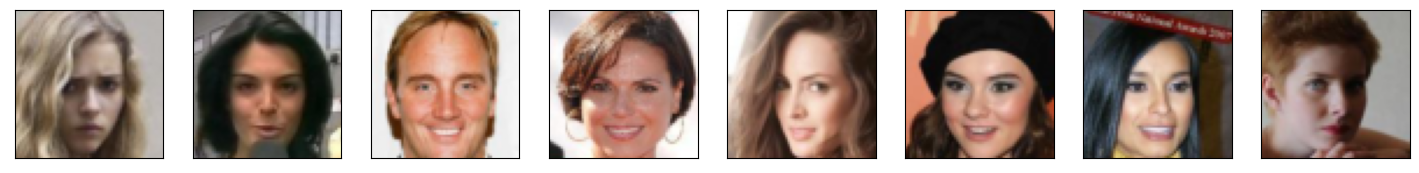

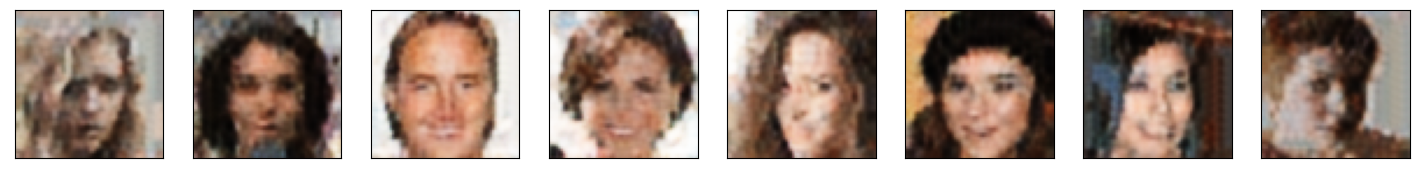

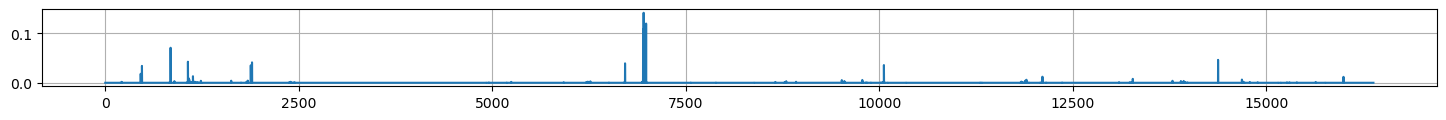

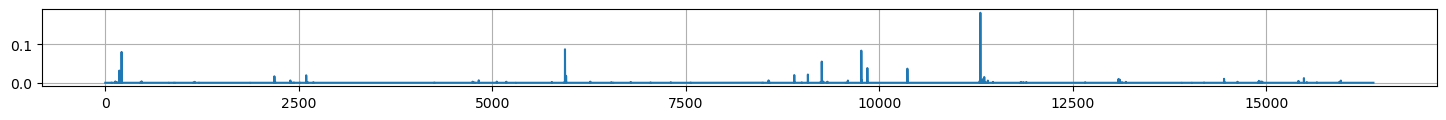

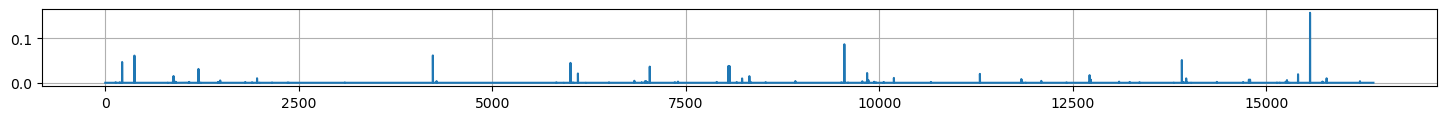

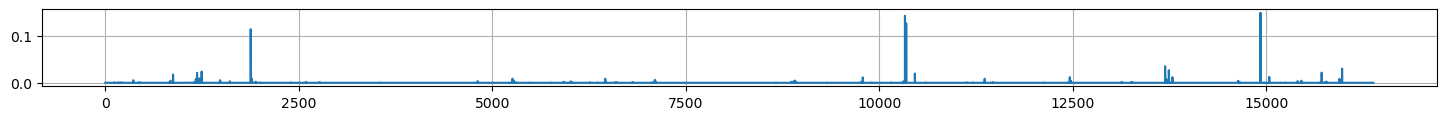

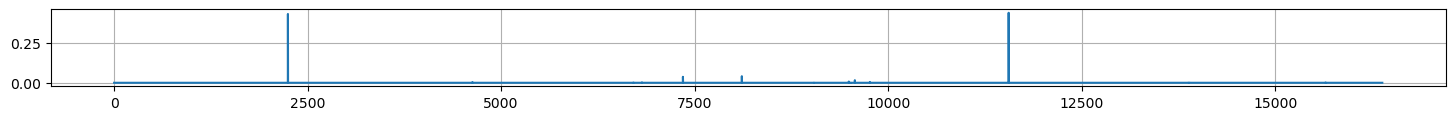

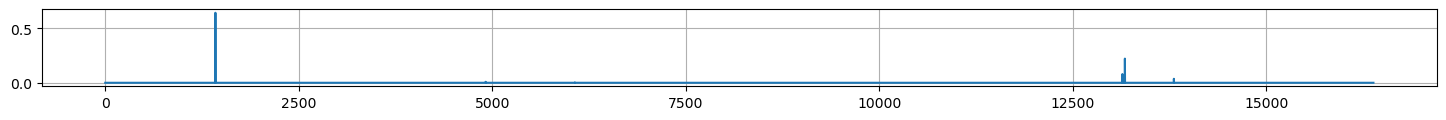

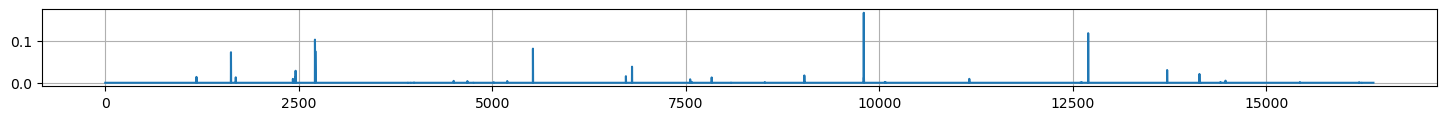

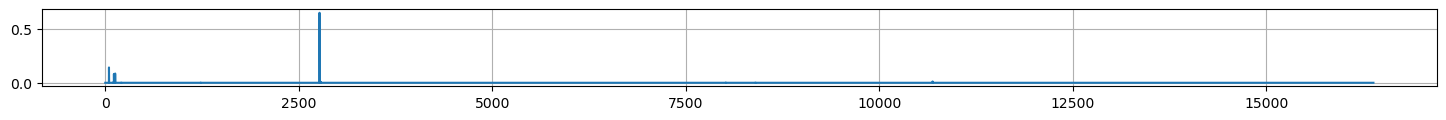

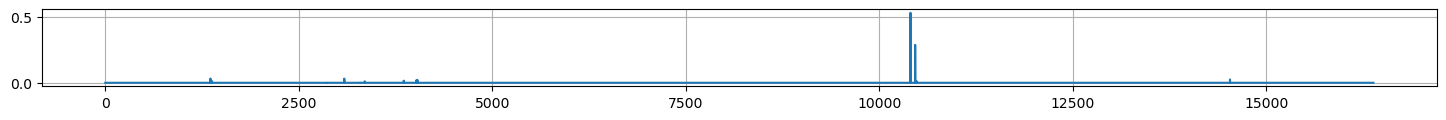

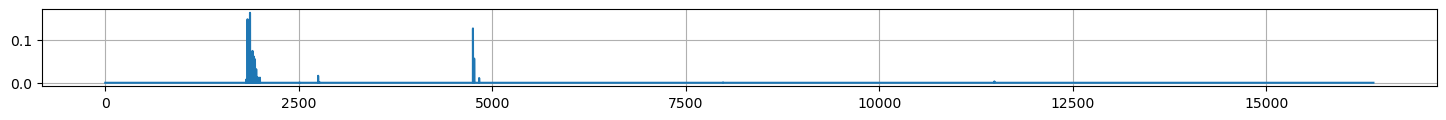

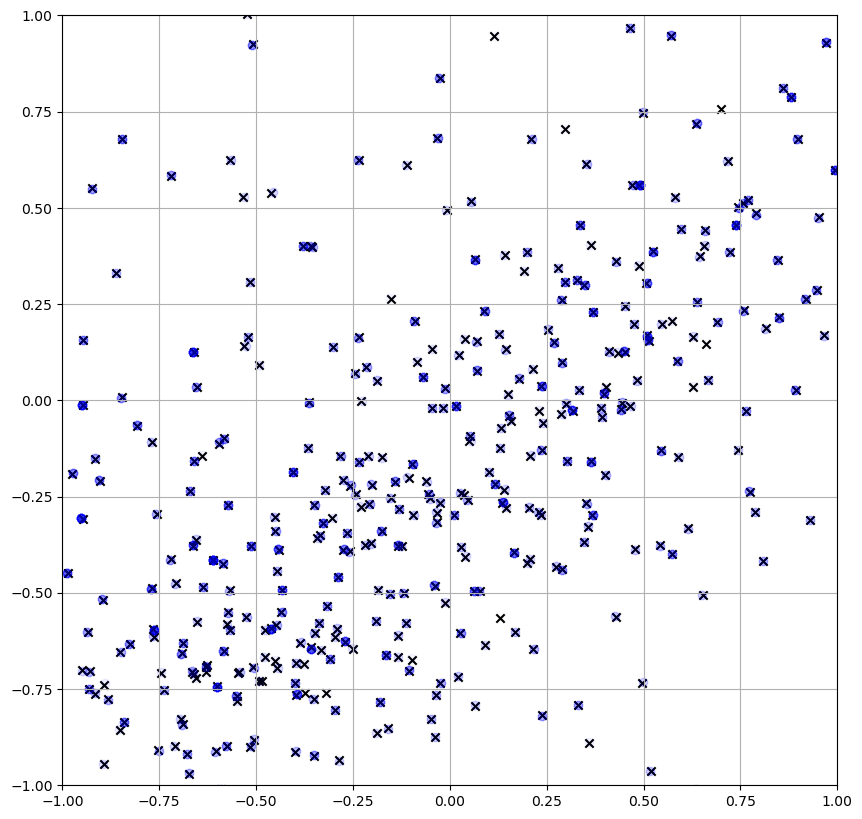

22001
lse_loss -159.40225219726562
commit_loss 0.00485920999199152
recon_loss 0.0007301141740754247
22002
lse_loss -160.05690002441406
commit_loss 0.004204184282571077
recon_loss 0.0007540021906606853
22003
lse_loss -159.64195251464844
commit_loss 0.004259023815393448
recon_loss 0.0007904476951807737
22004
lse_loss -159.7989959716797
commit_loss 0.0038654659874737263
recon_loss 0.0006349124014377594
22005
lse_loss -159.93023681640625
commit_loss 0.004535974934697151
recon_loss 0.0007319270516745746
22006
lse_loss -160.0044708251953
commit_loss 0.0043378607369959354
recon_loss 0.0007755829719826579
22007
lse_loss -159.99000549316406
commit_loss 0.0042472886852920055
recon_loss 0.0009022137965075672
22008
lse_loss -160.17172241210938
commit_loss 0.0036686547100543976
recon_loss 0.0005064142751507461
22009
lse_loss -160.00360107421875
commit_loss 0.004084410145878792
recon_loss 0.0006229723803699017
22010
lse_loss -160.00172424316406
commit_loss 0.004156885668635368
recon_loss 0.000728599

lse_loss -160.53770446777344
commit_loss 0.003986665979027748
recon_loss 0.0005571990041062236
22085
lse_loss -160.47727966308594
commit_loss 0.004236217588186264
recon_loss 0.0005815314943902194
22086
lse_loss -160.44300842285156
commit_loss 0.0039408523589372635
recon_loss 0.0005926864105276763
22087
lse_loss -160.57144165039062
commit_loss 0.00404762988910079
recon_loss 0.0007075436878949404
22088
lse_loss -160.42771911621094
commit_loss 0.003948657773435116
recon_loss 0.0005687184166163206
22089
lse_loss -160.491455078125
commit_loss 0.004221484065055847
recon_loss 0.0005624510231427848
22090
lse_loss -160.59027099609375
commit_loss 0.004333235323429108
recon_loss 0.0005898262606933713
22091
lse_loss -160.4554901123047
commit_loss 0.004141013137996197
recon_loss 0.0006014822865836322
22092
lse_loss -160.23704528808594
commit_loss 0.0047791143879294395
recon_loss 0.0007093939930200577
22093
lse_loss -160.48667907714844
commit_loss 0.00422352459281683
recon_loss 0.000578409293666482


lse_loss -161.09603881835938
commit_loss 0.003920969553291798
recon_loss 0.000582746637519449
22167
lse_loss -160.5915069580078
commit_loss 0.004400452133268118
recon_loss 0.0005824255640618503
22168
lse_loss -160.99391174316406
commit_loss 0.00410517118871212
recon_loss 0.0005413340404629707
22169
lse_loss -161.0217742919922
commit_loss 0.003833979135379195
recon_loss 0.0005680127069354057
22170
lse_loss -160.88319396972656
commit_loss 0.003986611030995846
recon_loss 0.0005761883803643286
22171
lse_loss -160.97250366210938
commit_loss 0.004092738498002291
recon_loss 0.0006698791403323412
22172
lse_loss -161.059814453125
commit_loss 0.0037740268744528294
recon_loss 0.0005177769344300032
22173
lse_loss -161.03164672851562
commit_loss 0.0040497202426195145
recon_loss 0.0005610579391941428
22174
lse_loss -161.16232299804688
commit_loss 0.003666937816888094
recon_loss 0.0005728363175876439
22175
lse_loss -161.0674285888672
commit_loss 0.004126362502574921
recon_loss 0.0005919879768043756
2

22249
lse_loss -161.67547607421875
commit_loss 0.003720620647072792
recon_loss 0.0005119756679050624
22250
lse_loss -161.2697296142578
commit_loss 0.004371108487248421
recon_loss 0.0006445361650548875
22251
lse_loss -161.45257568359375
commit_loss 0.0038851238787174225
recon_loss 0.0007270813221111894
22252
lse_loss -161.4240264892578
commit_loss 0.0043394910171628
recon_loss 0.0005638537695631385
22253
lse_loss -161.7838134765625
commit_loss 0.003812088631093502
recon_loss 0.0005943779833614826
22254
lse_loss -161.52903747558594
commit_loss 0.004035858437418938
recon_loss 0.0006370213814079762
22255
lse_loss -161.5359344482422
commit_loss 0.004077821038663387
recon_loss 0.0005801250226795673
22256
lse_loss -161.12950134277344
commit_loss 0.004240184091031551
recon_loss 0.0005620700540021062
22257
lse_loss -161.66351318359375
commit_loss 0.0038317088037729263
recon_loss 0.0005442893016152084
22258
lse_loss -161.6636962890625
commit_loss 0.0037286693695932627
recon_loss 0.00065968581475

lse_loss -162.11404418945312
commit_loss 0.0038135580252856016
recon_loss 0.0005529371555894613
22332
lse_loss -161.93109130859375
commit_loss 0.004171658307313919
recon_loss 0.0006635237368755043
22333
lse_loss -162.1015167236328
commit_loss 0.003870920278131962
recon_loss 0.000545735820196569
22334
lse_loss -161.98170471191406
commit_loss 0.003782863263040781
recon_loss 0.0005686465883627534
22335
lse_loss -161.72299194335938
commit_loss 0.0041979774832725525
recon_loss 0.000805671326816082
22336
lse_loss -162.13714599609375
commit_loss 0.0039654867723584175
recon_loss 0.0005510062328539789
22337
lse_loss -162.04864501953125
commit_loss 0.004007008858025074
recon_loss 0.0006483782199211419
22338
lse_loss -161.7254638671875
commit_loss 0.004422975704073906
recon_loss 0.0008448491571471095
22339
lse_loss -161.90475463867188
commit_loss 0.003990304656326771
recon_loss 0.0006420590216293931
22340
lse_loss -162.0621795654297
commit_loss 0.003643888747319579
recon_loss 0.000519904424436390

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)
            
            # Forward
            model.train()
            model.zero_grad()
            data = model(data, latent_temp=1)

            # Backward
            loss = 0
            for key in data.keys():
                if 'lse_loss' in key:
                    loss = loss + data[key] * 1e-4
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'commit_loss' in key:
                    loss = loss + data[key] * 0
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]        
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
            
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 100 == 0:
            loss_dict = {}
            for model in model_list:
                data = preprocess(batch)
                
                # Forward
                model.eval()
                with torch.no_grad():
                    data = model(data, latent_temp=1, quantize=True)

                for key in data.keys():
                    if 'loss' in key:
                        if key in loss_dict:
                            loss_dict[key].append(data[key].item())
                        else:
                            loss_dict[key] = [data[key].item()]
                        
            writer.add_scalar('eval_recon_loss', np.mean(loss_dict['recon_loss']), step)
            
        if step % 1000 == 0:
            
            log_sigma = model.latent.log_sigma.item()
            writer.add_scalar('log_sigma', log_sigma, step)
            
            usage = ((data['belong'].sum(dim=0) > 0).sum() / hp.M).item()
            writer.add_scalar('usage', usage, step)            

            import matplotlib.pyplot as plt
            display.clear_output()
            
            x = data['x']
            y = data['y']
            
            plot(x)
            plot(y)
                        
            grad = torch.softmax(data['matrix'], dim=0)
            grad = grad.data.cpu().numpy()

            import matplotlib.pyplot as plt

            for i in np.random.randint(0, grad.shape[1], size=[10]):
                plt.figure(figsize=[18, 1])
                plt.plot(grad[:, i])
                plt.grid()
                plt.show()
            
            from sklearn.decomposition import PCA
            pca = PCA(n_components=2)
            e = model.prior.prior.data.cpu().numpy()
            pca.fit(e)
            e_pca = pca.transform(e)
            z_pca = pca.transform(data['z'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
            plt.figure(figsize=[10, 10])
            plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=1.0, color='black')
            plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='o', alpha=0.01, color='blue')
            plt.xlim([-1, 1])
            plt.ylim([-1, 1])
            plt.grid()
            plt.show() 
            
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [ ]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')